In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read in the NYT data, updated daily at: 
#  https://github.com/nytimes/covid-19-data
counties_original = pd.read_csv('us-counties.csv')
states_original = pd.read_csv('us-states.csv')
# Sometimes I refer to counties it as simply 'df'
df = counties_original

# For per-capita analysis, import state-level populations
df_pop = pd.read_csv('population.csv')

# Cast date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Get the most recent date in the dataframes (data should go up to the day before this dataset is published by NYT)
date_for_analysis = df.date.max()


# 1. Initial Look at the Data and Some Basic Graphs

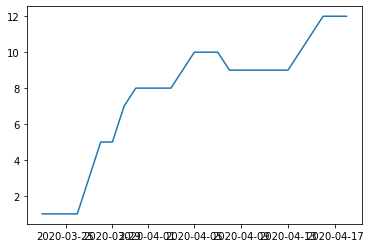

In [49]:
# Plot cumulative cases for my home county (Sherburne, Minnesota)
sherburne = counties_original[counties_original['county']=='Sherburne']
plt.plot(sherburne['date'], sherburne['cases'])

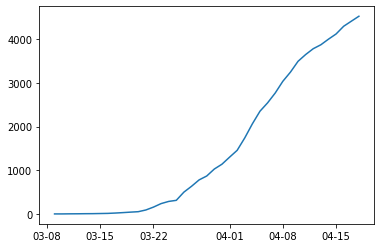

In [50]:
# The dates on the x-axis are very messy.
# Let's clean it up and look at cases in a friend's county in New Jersey:

# Monmouth, NJ
monmouth = df[df['county']=='Monmouth']
#plt.xticks(rotation=90)
myFmt = mdates.DateFormatter('%m-%d')

fig, ax = plt.subplots()
ax.plot(monmouth['date'], monmouth['cases'])

ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)


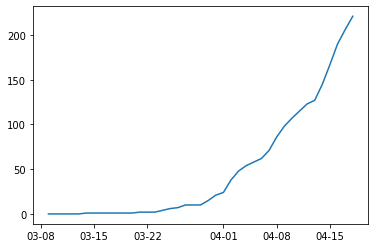

In [60]:
# Do the same for deaths :(
# Deaths in Monmouth
myFmt = mdates.DateFormatter('%m-%d')

fig, ax = plt.subplots()
ax.plot(monmouth['date'], monmouth['deaths'])


ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt)


In [61]:
# How many counties have had cases but no deaths?
# Answer: A LOT. Of counties with at least one case, 71% have seen no deaths (as of 4/19)
no_deaths = df[(df['cases'] > 0) & (df['deaths'] == 0)]

print("Ratio of counties with at least one case but no deaths:")
print(len(no_deaths) / len(df))

Ratio of counties with at least one case but no deaths:
0.7091486513429605


In [62]:
# Which county has the worst death rate? (perhaps above a certain threshold of cases, say, 100?)
df['death_rate'] = df['deaths'] / df['cases']
rate_sun = df[df['date']==date_for_analysis][['county','state', 'cases','deaths','death_rate']]

In [63]:
# Answer if cutting off at having at least 100 cases:
rate_sun[rate_sun['cases']>100].sort_values(['death_rate'], ascending=False).head(5)

,county,state,cases,deaths,death_rate
69298,Miami,Ohio,129,22,0.170543
68503,St. Landry,Louisiana,133,20,0.150376
69502,Unknown,Rhode Island,815,117,0.143558
69310,Portage,Ohio,168,24,0.142857
68566,Franklin,Massachusetts,177,25,0.141243


In [64]:
# If cases need to be above 1,000:
rate_sun[rate_sun['cases'] > 1000].sort_values(['death_rate'], ascending=False).head(5)

,county,state,cases,deaths,death_rate
68599,Genesee,Michigan,1228,112,0.091205
67734,Hartford,Connecticut,3196,289,0.090426
68622,Macomb,Michigan,4251,384,0.090332
68567,Hampden,Massachusetts,2254,203,0.090062
69465,Lancaster,Pennsylvania,1113,93,0.083558


## Analyzing US States on a Per-Capita Basis

In [67]:
# Group by state
state_group = rate_sun[['state', 'cases', 'deaths']].groupby('state').sum()

merged = state_group.merge(df_pop[['NAME','POPESTIMATE2019']], left_on='state', right_on='NAME')

merged['cases_per_million'] = (merged['cases'] / merged['POPESTIMATE2019']) * 1000000

merged['deaths_per_million'] = (merged['deaths'] / merged['POPESTIMATE2019']) * 1000000

# Ordered by best case-rates
case_rates = merged.sort_values('cases_per_million', ascending=True).reset_index()
case_rates.head(15)

,index,cases,deaths,NAME,POPESTIMATE2019,cases_per_million,deaths_per_million
0,39,1068,58,Puerto Rico,3193694,334.408995,18.160788
1,23,2213,121,Minnesota,5639632,392.401490,21.455301
2,26,426,10,Montana,1068778,398.586049,9.356480
3,11,568,9,Hawaii,1415872,401.166207,6.356507
4,1,312,7,Alaska,731545,426.494611,9.568789
5,37,1844,72,Oregon,4217737,437.201276,17.070766
6,49,825,18,West Virginia,1792147,460.341702,10.043819
7,51,309,2,Wyoming,578759,533.900985,3.455670
8,33,6140,175,North Carolina,10488084,585.426280,16.685602
9,3,1777,38,Arkansas,3017804,588.838772,12.591938


In [ ]:
# The above indicates Minnesota is the best US state for cases per-capita

# 2. Generating Additional Columns and Plotting the "New Cases Curves"

## Functions 

In [51]:
'''
Returns a new dataframe with three additional columns: new_cases and new_deaths (per day), and days_since_first_case
Makes a copy of the df so that the df passed-in is not changed.

Parameters: 
df_orig: the NYT database (either county or state depending on interest). 
Note if you want entire US output, input state-level data
  (ie there's no need to bother with the US dataframe that the NYT is now providing)
county_bool: Set to True if interested in county-level data, otherwise set to False
state_bool: Set to True if interested in state-level data, otherwise set to False
Note: If interested in overall-US data, set both booleans to False

Returns:
 a new dataframe with columns for new_cases, new_deaths, and days_since_first_case
'''

def generate_new_columns(df_orig, county_bool, state_bool):
    df = df_orig.copy()
    
    df = df.merge(df, on='fips')

    df = df[pd.DatetimeIndex(df['date_x']) == pd.DatetimeIndex(df['date_y']) + pd.DateOffset(1)]
    df['new_cases'] = df.cases_x - df['cases_y']
    df['new_deaths'] = df.deaths_x - df['deaths_y']
    
    # Get the date of the first case for each geographic area ("fips")
    # Note: If using county-level dataframe, "unknown" cases will be dropped at this point
    #  this should not be an issue since the user is interested in county-level data if using the county df
    fips_min_date = df.groupby(['fips'])[['date_y']].min().reset_index()
    
    fips_min_date = fips_min_date.merge(df, on='fips').copy()
    fips_min_date = fips_min_date[fips_min_date['date_y_y'] == fips_min_date['date_y_x']].copy()
    
    # Clean up columns
    if county_bool:
        date_clean = fips_min_date[['fips', 'date_y_x', 'county_x', 'state_x', 'cases_y','deaths_y']].copy()
    else:
        date_clean = fips_min_date[['fips', 'date_y_x', 'state_x', 'cases_y','deaths_y']].copy()
    
    date_clean['new_cases'] = fips_min_date['cases_y'].copy()
    date_clean['new_deaths'] = fips_min_date['deaths_y'].copy()
    
    if county_bool:
        col_names = ['fips', 'date', 'county', 'state', 'cases', 'deaths', 'new_cases', 'new_deaths']
    else:
        col_names = ['fips', 'date', 'state', 'cases', 'deaths', 'new_cases', 'new_deaths']
    date_clean.columns = col_names
    
    # Clean up counties df in similar way
    if county_bool:
        counties_clean = df.rename(columns={'date_x': 'date', 'county_x': 'county', 'state_x': 'state', 'cases_x':'cases', 'deaths_x':'deaths', 'POPESTIMATE2019_x':'state_pop'})
    else:
        counties_clean = df.rename(columns={'date_x': 'date', 'state_x': 'state', 'cases_x':'cases', 'deaths_x':'deaths', 'POPESTIMATE2019_x':'state_pop'})
    
    # Merge the dataframes together
    fulldf = pd.concat([date_clean, counties_clean])
    date_clean = date_clean.rename(columns={'date':'first_case_date'})
    fulldf = fulldf.merge(date_clean[['fips', 'first_case_date']], on='fips')
    
    fulldf['date'] = pd.to_datetime(fulldf['date'], format='%Y-%m-%d')
    fulldf['first_case_date'] = pd.to_datetime(fulldf['first_case_date'], format='%Y-%m-%d')
    
    # If doing county-level or state-level data
    if county_bool or state_bool:
        fulldf['days_since_first_case'] = (fulldf['date'] - fulldf['first_case_date']).dt.days

        # Do a final clean-up of columns before returning
        if county_bool:
            fulldf = fulldf[['cases', 'county', 'date', 'deaths', 'fips', 'new_cases', 'new_deaths', 'state', 'days_since_first_case']]
        else:
            fulldf = fulldf[['cases', 'date', 'deaths', 'fips', 'new_cases', 'new_deaths', 'state', 'days_since_first_case']]
        return fulldf
    # Else doing entire US
    else:
        us_df = fulldf.groupby('date').sum().reset_index()
        first_date_in_us = us_df['date'].min()
        
        us_df['days_since_first_case'] = (us_df['date'] - first_date_in_us).dt.days
        
        # final clean-up
        us_df = us_df[['cases', 'date', 'deaths', 'new_cases', 'new_deaths', 'days_since_first_case']]

        return us_df

In [52]:
'''
Plot the "new cases curve" (ie days_since_first_case on x-axis, number of new cases that day on the y-axis)
This function can be used to graph a particular county, a particular state, or the entire US combined.

Parameters:
county_name: String of the county's name. Pass in the boolean False if not interested in county-level graph
state_name: String of the state's name. Pass in the boolean False if not interested in state-level graph
fulldf: The dataframe that was created by utilizing the previous function, generate_new_columns

Returns:
This function does not return anything but rather plots the appropriate graph.
'''
def graph_curve(county_name, state_name, fulldf):

    if county_name:
        df = fulldf[(fulldf['county']==county_name) & (fulldf['state']==state_name)]
    elif state_name:
        df = fulldf[fulldf['state']==state_name]
    else:
        df = fulldf
        
    fig = plt.figure()

    ax1 = fig.add_subplot(211)
    ax1.set_ylabel('new cases')
    ax1.set_xlabel('days since first case')
    if county_name:
        ax1.set_title('new cases curve: ' + county_name + ' County, '+state_name)
    elif state_name:
        ax1.set_title('new cases curve: State of ' +state_name)
    else:
        ax1.set_title('new cases curve: entire United States')

    line, = ax1.plot(df.days_since_first_case, df.new_cases, lw=2)

    plt.show()

## Making use of the functions and data

In [53]:
counties_cases = generate_new_columns(counties_original, True, False)


In [54]:
# Have a look at the county-level dataframe
counties_cases.head()

,cases,county,date,deaths,fips,new_cases,new_deaths,state,days_since_first_case
0,1,Autauga,2020-03-24,0,1001.0,1,0,Alabama,0
1,4,Autauga,2020-03-25,0,1001.0,3,0,Alabama,1
2,6,Autauga,2020-03-26,0,1001.0,2,0,Alabama,2
3,6,Autauga,2020-03-27,0,1001.0,0,0,Alabama,3
4,6,Autauga,2020-03-28,0,1001.0,0,0,Alabama,4


In [55]:
overall_us = generate_new_columns(states_original, False, False)

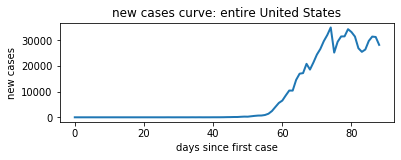

In [56]:
# Graph the entire US 
graph_curve(False, False, overall_us)

In [57]:
states_cases = generate_new_columns(states_original, False, True)

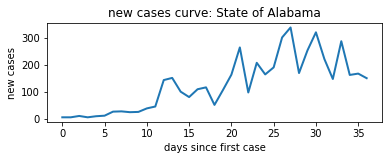

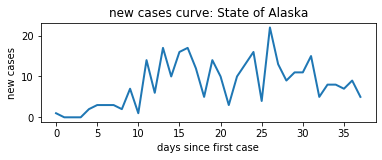

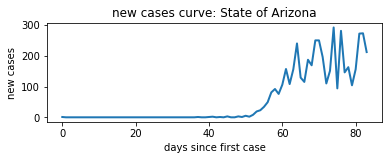

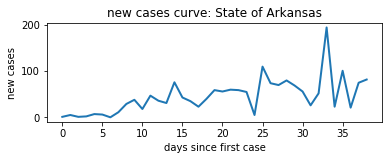

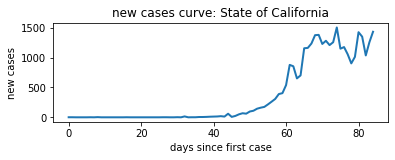

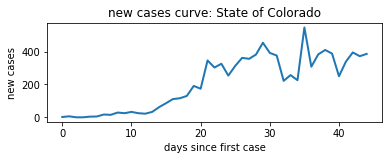

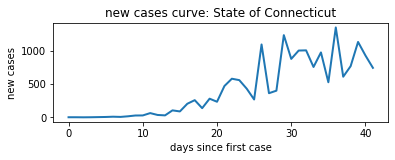

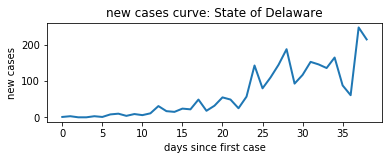

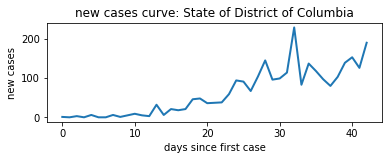

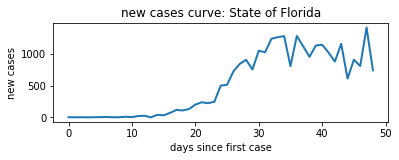

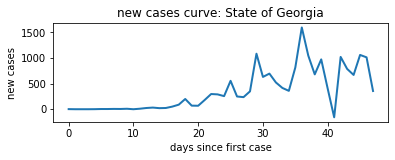

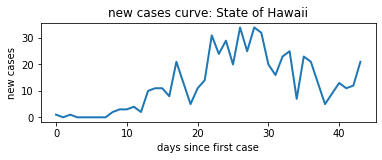

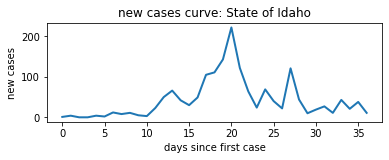

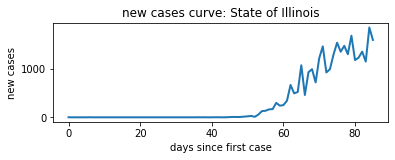

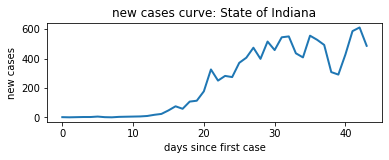

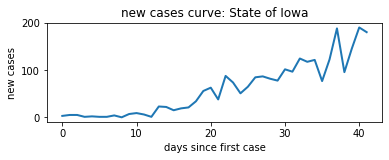

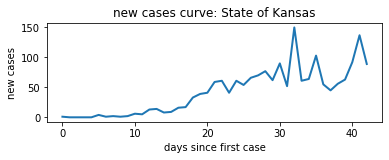

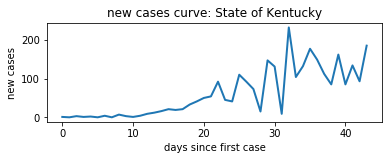

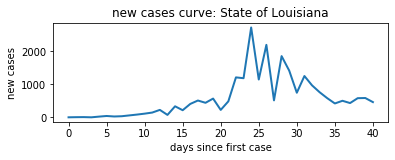

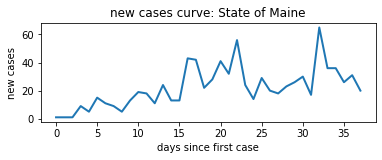

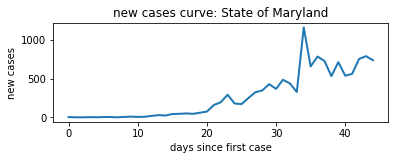

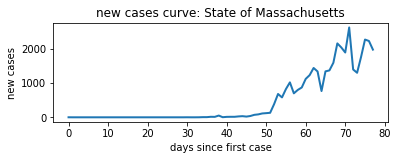

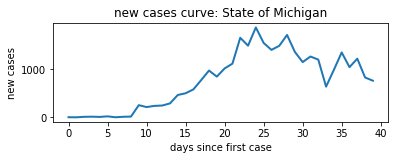

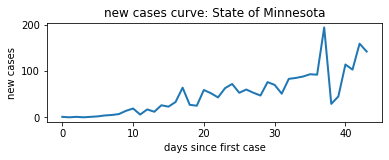

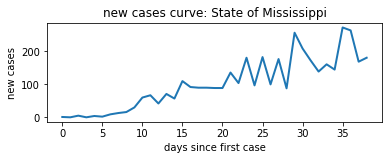

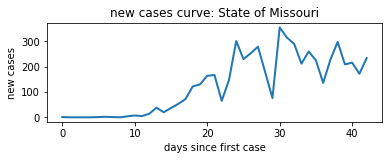

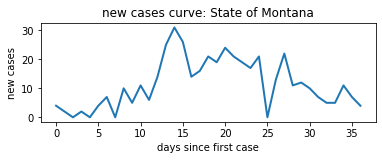

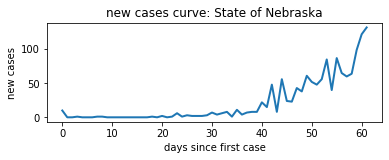

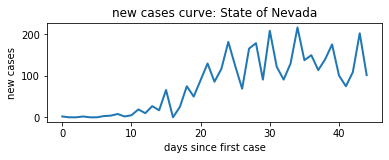

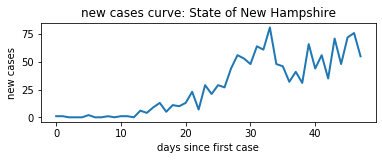

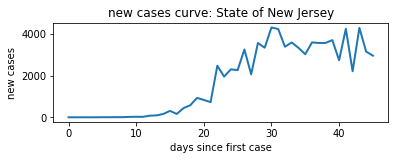

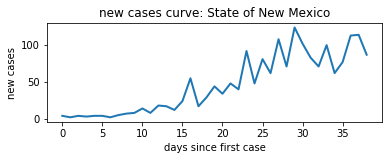

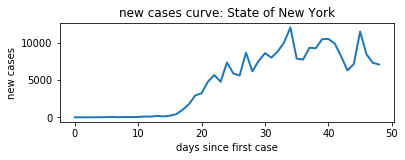

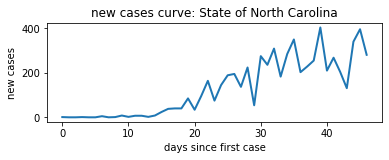

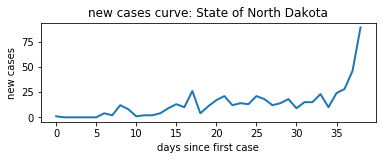

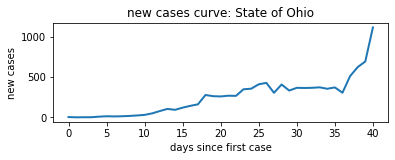

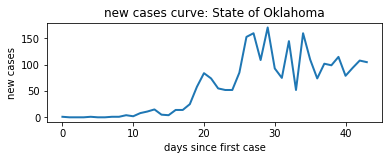

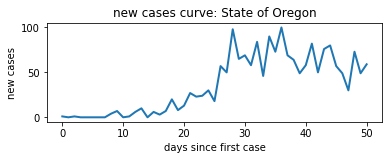

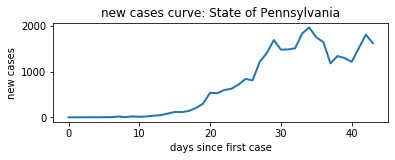

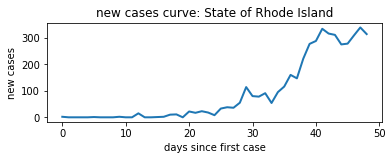

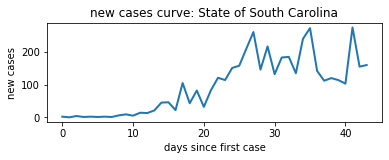

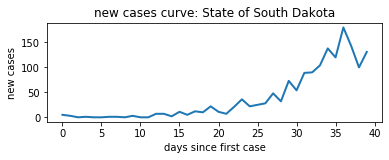

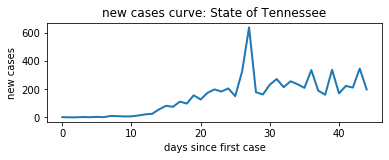

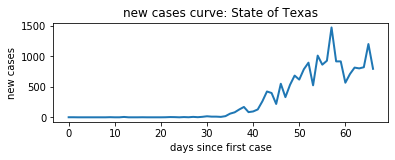

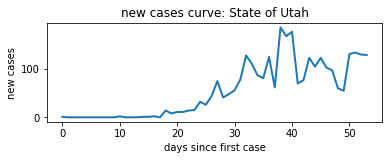

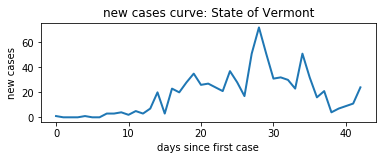

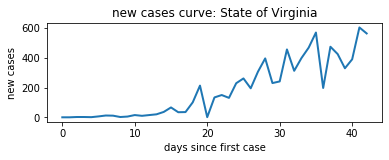

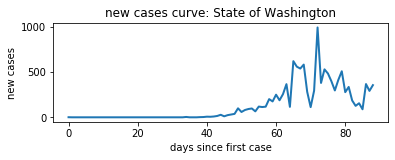

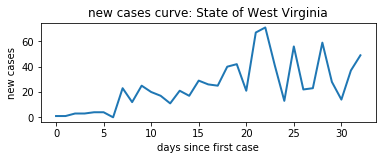

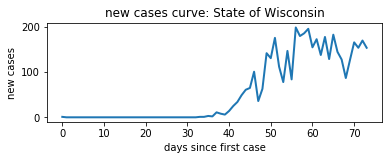

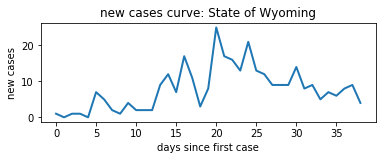

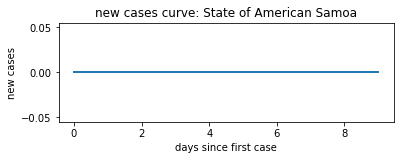

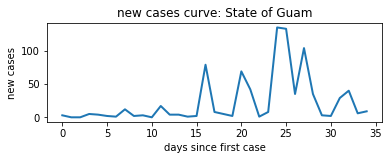

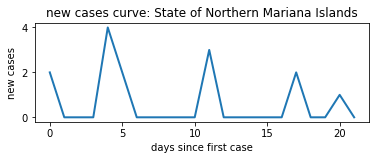

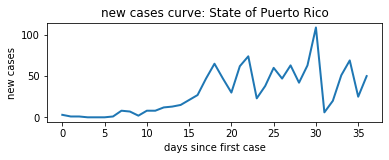

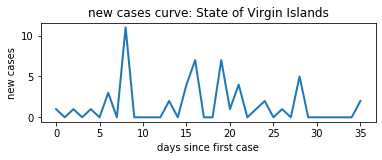

In [58]:
# Graph all 50 states (and additional US territories)

all_states = states_cases['state'].unique()

for state in all_states:
    graph_curve(False, state, states_cases)

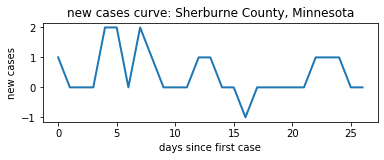

In [59]:
# Graph my home county:
# Note that a negative new-cases number means that (at least) one person was moved outside the county on that day
graph_curve("Sherburne", "Minnesota", counties_cases)